In [72]:
##############
#K. David Roell CFPB 
#expands data selection for quality edits to include context for developing statistical approaches
#will attemtp to segment mortgage market participants by loan activity by:
#volume/count of lending, income of applicants, securitization, property type and other factors
##############

import json
import os
import pandas as pd
import psycopg2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
get_ipython().magic(u'matplotlib inline')
matplotlib.style.use('ggplot')

with open('../quality_sql.json') as f: #FIXME change to quality_sql.json and refactor the rest of code
    edit_sql = json.load(f)
    
#parameter format for local use #consider changing hmdamaster to roellk if db changes cause a fail
params = {
'dbname':'hmdamaster',
'user':'roellk',
'password':'',
'host':'localhost',
}

try:
    conn = psycopg2.connect(**params)
    cur = conn.cursor()
    print("i'm connected")

except psycopg2.Error as e: #if database connection results in an error print the following
    print("I am unable to connect to the database: ", e)

i'm connected


In [73]:
#get distributions of values for fields
def field_dist_geo(field1=None, field2=None, table=None, geo_level=None, prop_type="'1', '2', '3'", loan_purp="'1','2','3'", loan_type="'1','2','3','4'", occupancy="'1','2','3'", lien="'1','2','3'"):
    """generates a sql statement used to pull values and associated counts for the listed variable subject to listed filters"""
    if field1 is None or field2 is None:
        raise ValueError("both field1 and field2 must be populated")
    for key, value in kwargs.items():
        
        #convert geo_level to SQL text
        if geo_level == 'msa':
            geo_sql = 'msa,'
        elif geo_level == 'state':
            geo_sql = 'state,'
        elif geo_level == 'county':
            geo_sql = 'CONCAT(state,county),'
        elif geo_level == 'tract':
            geo_sql = 'CONCAT(state,county,tract),'
        else:
            geo_sql = ''
    
    dist_sql = """SELECT DISTINCT year, {geo_sql} {field1}, {field2}
    FROM {table} """.format(table=table, field1=field1, field2=field2, geo_sql=geo_sql) 

    #removing the bulk of quesitonable data in exploration by removing HUD
    where_sql = """WHERE agency != '7' AND property_type IN ({prop_type}) AND loan_purpose IN ({loan_purp}) 
    AND loan_type IN ({loan_type}) AND occupancy IN ({occupancy}) AND lien IN ({lien}) AND income NOT ILIKE '%NA%'
    AND amount NOT ILIKE '%NA%' 
    """.format(prop_type=prop_type, loan_purp=loan_purp, loan_type=loan_type, occupancy=occupancy, lien=lien)

    group_sql = """GROUP BY year, {geo_group} {field1}, {field2}""".format(field1=field1, field2=field2, geo_group=geo_sql)
    order_sql = """ ORDER by {field1}, {field2} ASC """.format(field1=field1, field2=field2)
    return_sql = dist_sql + where_sql + group_sql + order_sql #combine sql parts to form query
    print(return_sql) #print query to monitor progress
    return return_sql #return completed sequel
#test 90000451965

In [74]:
def get_field_dist(year=None, field1=None, field2=None, geo_level='', prop_type="'1', '2', '3'", loan_purp="'1','2','3'", loan_type="'1','2','3','4'", occupancy="'1','2','3'", lien="'1','2','3'"):
    """executes SQL to get distributions of data by selected geography for the stated field for multiple years of hmda"""
    first = True
    while year > 2003:
        table = 'hmdalar' + str(year)
        print(table) #print table name to monitor progress
        
        #execute SQL query
        cur.execute(field_dist_geo(table=table, field1=field1, field2=field2, geo_level=geo_level, prop_type=prop_type,  loan_purp=loan_purp, occupancy=occupancy, lien=lien))        
        data_df = pd.DataFrame(cur.fetchall()) #put query results in dataframe

        col_names = [desc[0] for desc in cur.description] #get column names from SQL table
        
        if len(data_df.columns) == len(col_names):
            print('setting column names')
            data_df.columns = col_names #apply column names to dataframe

        if first == True and len(data_df.columns) > 0:
            dist_df = data_df.copy() #if first instance of dataframe, create master copy as dist_df
            first = False

        elif first == False and len(data_df.columns) > 0:
            print('merging dataframes')
            dist_df=pd.concat([dist_df, data_df]) #concatenate subsequent dataframes onto dist_df

        else:
            print('no data returned from query')

        print(dist_df.tail())
        path = '../data/' #set data path
        if not os.path.exists(path):
            os.makedirs(path)

        year -= 1 #decrement year to change hmda table
    #write dataframe to csv file
    dist_df.to_csv(path + '{field1}_to_{field2}_dist_{geo_level}_{loanType}.csv'.format(field1=field1, field2=field2, geo_level=geo_level, loanType=loanType),index=False)

loanType = 'RHS'
if loanType == 'all':
    loanCodes = "'1', '2', '3', '4'"
elif loanType == 'CONV':
    loanCodes = "'1'"
elif loanType == 'VA':
    loanCodes = "'2'"
elif loanType == 'FHA':
    loanCodes = "'3'"
elif loanType == 'RHS':
    loanCodes = "'4'"
    

In [75]:

kwargs={'year':2014,
        'field1':'income',
        'field2':'amount',
        'loan_type': loanCodes,
        'loan_purp':'1',
        'prop_type':'1',
        'occupancy':'1',
        'lien':'1'}
#get_field_dist(**kwargs) #kwargs format for submitting multiple filter arguments
get_field_dist(year=2014, field1='income', field2='amount')

hmdalar2014
SELECT DISTINCT year,  income, amount
    FROM hmdalar2014 
WHERE agency != '7' AND property_type IN ('1', '2', '3') AND loan_purpose IN ('1','2','3') 
    AND loan_type IN ('1','2','3','4') AND occupancy IN ('1','2','3') AND lien IN ('1','2','3') AND income NOT ILIKE '%NA%'
    AND amount NOT ILIKE '%NA%' 
    
SELECT DISTINCT year,  income, amount
    FROM hmdalar2014 WHERE agency != '7' AND property_type IN ('1', '2', '3') AND loan_purpose IN ('1','2','3') 
    AND loan_type IN ('1','2','3','4') AND occupancy IN ('1','2','3') AND lien IN ('1','2','3') AND income NOT ILIKE '%NA%'
    AND amount NOT ILIKE '%NA%' 
    GROUP BY year,  income, amount ORDER by income, amount ASC 
setting column names
        year income amount
386576  2014   9999  18000
386577  2014   9999  21750
386578  2014   9999  24600
386579  2014   9999  25513
386580  2014   9999  29700
hmdalar2013
SELECT DISTINCT year,  income, amount
    FROM hmdalar2013 
WHERE agency != '7' AND property_type IN ('1', 

In [78]:
dist_df = pd.read_csv('../data/income_to_amount_dist__all.csv') #read csv data to dataframe
dist_df.sort_values('amount', inplace=True) #sort by column for graphing
hist_df.head(5)


amount
0             1
661397        1
660855        1
1861832       1
660320        1

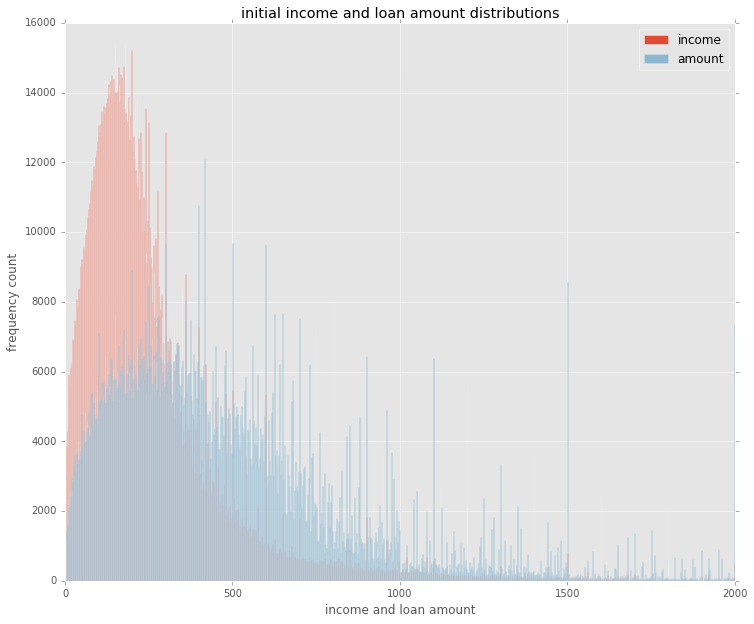

In [77]:
#graph data from csv to check distributions
amt = dist_df.amount #get data as series for graphing
inc = dist_df.income #get data as series for graphing
bins = np.linspace(0,2000, 1000) #set ranges and number of bins
bank_viz = plt.figure(figsize=(12,10)) #set plot size
plt.hist(inc, bins, label='income', alpha=1) #plot histogram of income
plt.hist(amt, bins, label='amount', alpha=.5) #plot histogram of loan amount
plt.legend(loc='upper right') #turn on legend and set location
plt.title('initial income and loan amount distributions')
plt.xlabel('income and loan amount')
plt.ylabel('frequency count')
plt.show()
#FIXME add 2 box plot viz